<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_7_3_Crossover_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Packages
!pip install livelossplot --quiet

In [ ]:
#@title Imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import math
import time
import random

import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras

In [ ]:
#@title Load Data
dataset = datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = dataset.load_data()

# normalize and reshape data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

x_train = x_train[:1000]
y_train= y_train[:1000]
x_test = x_test[:100]
y_test= y_test[:100]

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

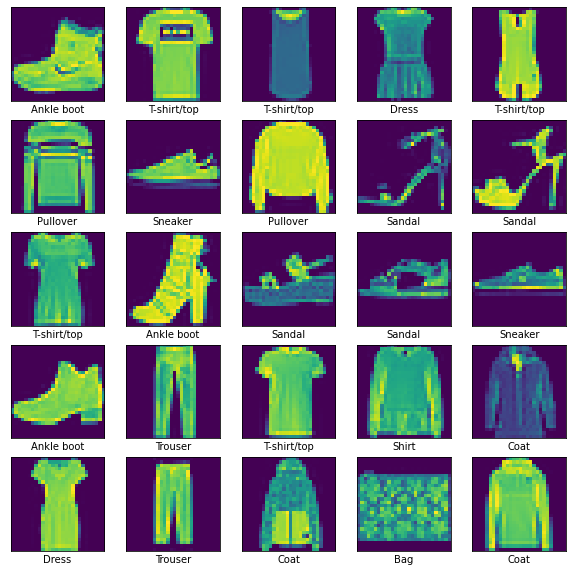

In [ ]:
def plot_data(num_images, images, labels):
  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28))
      plt.xlabel(class_names[labels[i]])      
  plt.show()

plot_data(25, x_train, y_train)

In [ ]:
#@title Constants
max_layers = 5
max_neurons = 128
min_neurons = 16
max_kernel = 5
min_kernel = 2
max_pool = 3
min_pool = 2

CONV_LAYER = -1
CONV_LAYER_LEN = 4
POOLING_LAYER = -2
POOLING_LAYER_LEN = 3
BN_LAYER = -3
BN_LAYER_LEN = 1
DENSE_LAYER = -4
DENSE_LAYER_LEN = 2

In [ ]:
#@title Encoding scheme
def generate_neurons():
  return random.randint(min_neurons, max_neurons)

def generate_kernel():
  part = []
  part.append(random.randint(min_kernel, max_kernel))
  part.append(random.randint(min_kernel, max_kernel))
  return part

def generate_bn_layer():
  part = [BN_LAYER] 
  return part

def generate_pooling_layer():
  part = [POOLING_LAYER] 
  part.append(random.randint(min_pool, max_pool))
  part.append(random.randint(min_pool, max_pool))
  return part

def generate_dense_layer():
  part = [DENSE_LAYER] 
  part.append(generate_neurons())  
  return part

def generate_conv_layer():
  part = [CONV_LAYER] 
  part.append(generate_neurons())
  part.extend(generate_kernel())
  return part

def create_offspring():
  ind = []
  for i in range(max_layers):
    if random.uniform(0,1)<.5:
      #add convolution layer
      ind.extend(generate_conv_layer())
      if random.uniform(0,1)<.5:
        #add batchnormalization
        ind.extend(generate_bn_layer())
      if random.uniform(0,1)<.5:
        #add max pooling layer
        ind.extend(generate_pooling_layer())
  ind.extend(generate_dense_layer())
  return ind
        
individual = create_offspring()
print(individual)


[-1, 33, 3, 3, -1, 78, 5, 2, -3, -2, 3, 3, -1, 45, 4, 4, -1, 72, 2, 3, -3, -1, 101, 3, 5, -2, 2, 3, -4, 68]


In [ ]:
def build_model(individual):
  model = models.Sequential()
  il = len(individual)
  i = 0
  while i < il:
    if individual[i] == CONV_LAYER: 
      n = individual[i+1]
      k = (individual[i+2], individual[i+3])
      i += CONV_LAYER_LEN
      if i == 0: #first layer, add input shape      
        model.add(layers.Conv2D(n, k, activation='relu', padding="same", input_shape=(28, 28, 1)))      
      else:
        model.add(layers.Conv2D(n, k, activation='relu', padding="same"))    
    elif individual[i] == POOLING_LAYER: #add pooling layer
      k = k = (individual[i+1], individual[i+2])
      i += POOLING_LAYER_LEN
      model.add(layers.MaxPooling2D(k, padding="same"))      
    elif individual[i] == BN_LAYER: #add batchnormal layer
      model.add(layers.BatchNormalization())
      i += 1      
    elif individual[i] == DENSE_LAYER: #add dense layer
      model.add(layers.Flatten())      
      model.add(layers.Dense(individual[i+1], activation='relu'))
      i += 2
  model.add(layers.Dense(10))
  return model

model = build_model(individual) 


In [ ]:
#@title Custom Crossover Operator
def get_layers(ind, layer_type):
  return [a for a in range(len(ind)) if ind[a] == layer_type]

def swap(ind1, iv1, ind2, iv2, ll):
  ch1 = ind1[iv1:iv1+ll]
  ch2 = ind2[iv2:iv2+ll]
  print(ll, iv1, ch1, iv2, ch2)
  ind1[iv1:iv1+ll] = ch2
  ind2[iv2:iv2+ll] = ch1
  return ind1, ind2

def swap_layers(ind1, ind2, layer_type, layer_len):
  c1, c2 = get_layers(ind1, layer_type), get_layers(ind2, layer_type) 
  min_c = min(len(c1), len(c2))
  for i in range(min_c):
    if random.random() < 1:
      i1 = random.randint(0, len(c1)-1)
      i2 = random.randint(0, len(c2)-1)      
      iv1 = c1.pop(i1)
      iv2 = c2.pop(i2)    
      ind1, ind2 = swap(ind1, iv1, ind2, iv2, layer_len) 
  return ind1, ind2 

def crossover(ind1, ind2):
  ind1, ind2 = swap_layers(ind1, ind2, CONV_LAYER, CONV_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, POOLING_LAYER, POOLING_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, BN_LAYER, BN_LAYER_LEN)
  ind1, ind2 = swap_layers(ind1, ind2, DENSE_LAYER, DENSE_LAYER_LEN)
  return ind1, ind2  

ind1 = create_offspring()
ind2 = create_offspring()
print(ind1)
print(ind2)

ind1, ind2 = crossover(ind1, ind2)
print(ind1)
print(ind2)

[-1, 126, 5, 5, -2, 3, 2, -1, 48, 5, 4, -2, 3, 2, -1, 127, 2, 3, -3, -1, 82, 4, 5, -3, -2, 2, 3, -4, 23]
[-1, 21, 5, 2, -3, -1, 103, 5, 5, -1, 97, 5, 2, -2, 2, 2, -4, 55]
4 14 [-1, 127, 2, 3] 5 [-1, 103, 5, 5]
4 19 [-1, 82, 4, 5] 9 [-1, 97, 5, 2]
4 0 [-1, 126, 5, 5] 0 [-1, 21, 5, 2]
3 11 [-2, 3, 2] 13 [-2, 2, 2]
1 18 [-3] 4 [-3]
2 27 [-4, 23] 16 [-4, 55]
[-1, 21, 5, 2, -2, 3, 2, -1, 48, 5, 4, -2, 2, 2, -1, 103, 5, 5, -3, -1, 97, 5, 2, -3, -2, 2, 3, -4, 55]
[-1, 126, 5, 5, -3, -1, 127, 2, 3, -1, 82, 4, 5, -2, 3, 2, -4, 23]


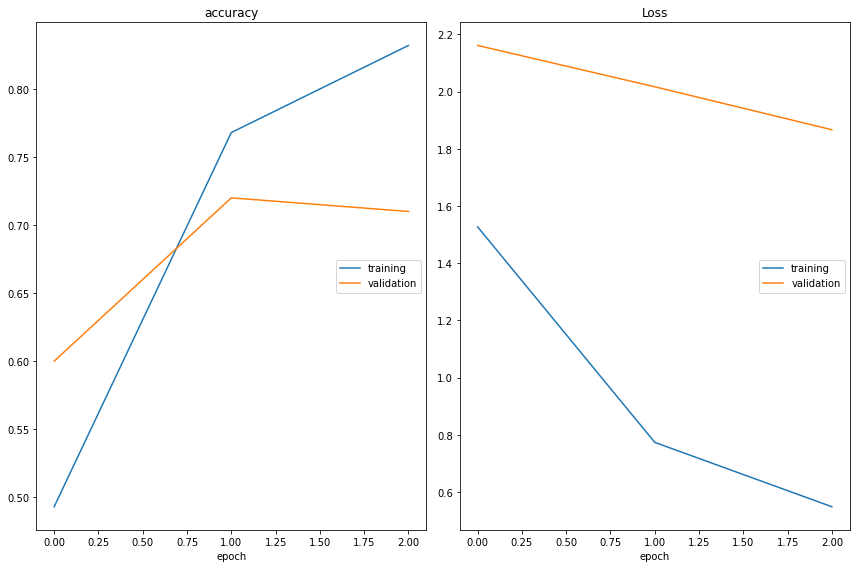

accuracy
	training         	 (min:    0.493, max:    0.832, cur:    0.832)
	validation       	 (min:    0.600, max:    0.720, cur:    0.710)
Loss
	training         	 (min:    0.549, max:    1.527, cur:    0.549)
	validation       	 (min:    1.866, max:    2.161, cur:    1.866)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 126)       3276      
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 126)      504       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 127)       96139     
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 82)        208362    
                                        

[1.8664010763168335, 0.7099999785423279]

In [ ]:
model = build_model(ind2) 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=3, 
                    validation_data=(x_test, y_test),
                    callbacks=[PlotLossesKeras()],
                    verbose=0)

model.summary()
model.evaluate(x_test, y_test)